In [3]:
import numpy as np
import requests
from collections import Counter
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

In [4]:
headers = {"accept": "application/json", "GROCY-API-KEY": "pN7OJvWIR2zTQqQOyT8ENlDuZ5k8t2oVHWNmEcaOd2omdcOJoY"}

product_log = requests.get("http://192.168.0.36:8040/api/objects/stock_log?query%5B%5D=product_id%3D148", headers=headers).json()

In [5]:
product_log

[{'id': 1464,
  'product_id': 148,
  'amount': -100,
  'best_before_date': '2023-03-30',
  'purchased_date': '2023-03-17',
  'used_date': '2023-04-28',
  'spoiled': 0,
  'stock_id': '6414d11e7a167',
  'transaction_type': 'consume',
  'price': None,
  'undone': 0,
  'undone_timestamp': None,
  'opened_date': '2023-03-17',
  'location_id': 5,
  'recipe_id': None,
  'correlation_id': None,
  'transaction_id': '644c136f2353c',
  'stock_row_id': None,
  'shopping_location_id': None,
  'user_id': 3,
  'row_created_timestamp': '2023-04-28 18:41:51',
  'note': 'Suntat Grün'},
 {'id': 2175,
  'product_id': 148,
  'amount': -200,
  'best_before_date': '2023-03-30',
  'purchased_date': '2023-03-17',
  'used_date': '2023-05-18',
  'spoiled': 0,
  'stock_id': '6414d11e7a167',
  'transaction_type': 'consume',
  'price': None,
  'undone': 0,
  'undone_timestamp': None,
  'opened_date': '2023-03-17',
  'location_id': 5,
  'recipe_id': 8,
  'correlation_id': None,
  'transaction_id': '6465d378240f3',
 

limit_output extension: Maximum message size of 10000 exceeded with 13753 characters

In [6]:
df = pd.DataFrame.from_dict(product_log, orient='columns')
df['row_created_timestamp'] = pd.to_datetime(df['row_created_timestamp'])
df['spoiled'] = df['spoiled'].astype(bool)
df['undone'] = df['undone'].astype(bool)
df = df.sort_values(by='row_created_timestamp')
df = df.set_index('row_created_timestamp')
df = df[df['transaction_type'].isin(['consume'])]
df = df[df['undone'] == False]
df = df[df['spoiled'] == False]
df['consumption'] = df['amount'] * (-1)
df = df[['consumption']]
df = df.append(pd.DataFrame({'consumption': 0}, index=[pd.to_datetime('2023-03-01')]))
df = df.append(pd.DataFrame({'consumption': 0}, index=[pd.Timestamp.now()]))
df = df.resample('1D').sum()
df['cum_consumption'] = df['consumption'].cumsum()
df = df[['cum_consumption']]

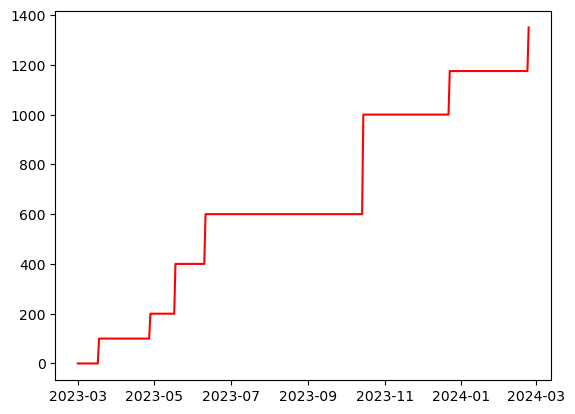

In [7]:
# plt.plot(df_final, color = "black", label = "Train")
plt.plot(df, color = "red", label = "Test")

In [8]:
train = df.iloc[:-50, :].copy()
test = df.iloc[-50:, :].copy()
pred = test.copy()
y = train

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86626D+00    |proj g|=  4.71192D-02

At iterate    5    f=  4.84395D+00    |proj g|=  8.03832D-02

At iterate   10    f=  4.75070D+00    |proj g|=  6.62387D-03

At iterate   15    f=  4.75068D+00    |proj g|=  2.73559D-04


 This problem is unconstrained.



At iterate   20    f=  4.75065D+00    |proj g|=  5.19472D-03

At iterate   25    f=  4.75008D+00    |proj g|=  4.40345D-03

At iterate   30    f=  4.74919D+00    |proj g|=  5.51056D-03

At iterate   35    f=  4.74819D+00    |proj g|=  1.91759D-02

At iterate   40    f=  4.74772D+00    |proj g|=  1.49108D-03

At iterate   45    f=  4.74765D+00    |proj g|=  9.31196D-05

At iterate   50    f=  4.74765D+00    |proj g|=  6.06057D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54      1     0     0   6.061D-06   4.748D+00
  F =   4.7476456003759759     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/home/aleks/.conda/envs/jupyter/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


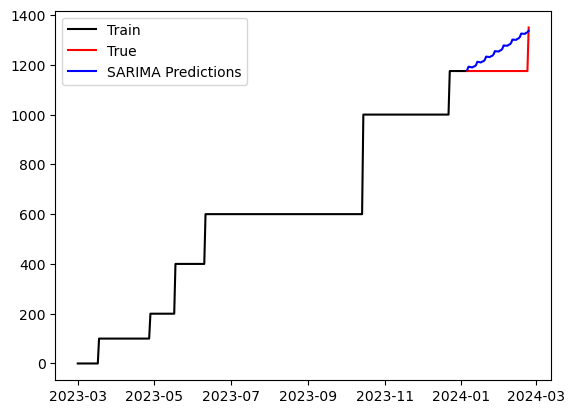

In [9]:
SARIMAXmodel = SARIMAX(y, order = (1, 1, 1), seasonal_order=(1,1,1,7))
SARIMAXmodel = SARIMAXmodel.fit(low_memory=True, cov_type='none')

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y, color = "black", label = "Train")
plt.plot(test, color = "red", label = "True")
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

/tmp/ipykernel_31047/138152063.py:2: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ARIMAmodel = ARIMAmodel.fit(method='innovations_mle', low_memory=True, cov_type='none')


RMSE:  134.00554195435836


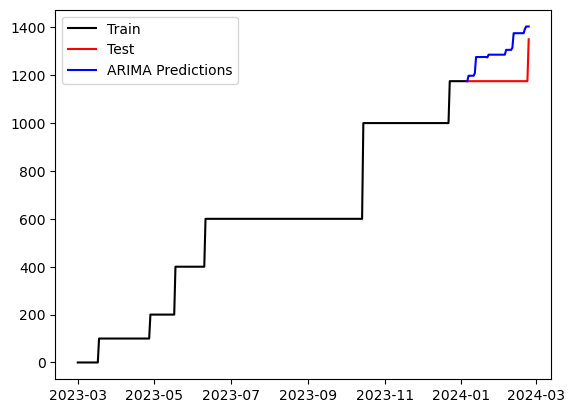

In [10]:
ARIMAmodel = ARIMA(y, order = (1, 1, 1), seasonal_order=(1,1,1,30))
ARIMAmodel = ARIMAmodel.fit(method='innovations_mle', low_memory=True, cov_type='none')

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y, color = "black", label = "Train")
plt.plot(test, color = "red", label = "Test")
plt.plot(y_pred_out, color='blue', label = 'ARIMA Predictions')
plt.legend()


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [11]:
model = SARIMAX(df, order = (1, 1, 1), seasonal_order=(1,1,1,7))
model = model.fit(low_memory=True, cov_type='none')
model.save('file')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84486D+00    |proj g|=  5.49512D-02

At iterate    5    f=  4.81995D+00    |proj g|=  1.85302D-02

At iterate   10    f=  4.73825D+00    |proj g|=  5.95882D-03

At iterate   15    f=  4.73822D+00    |proj g|=  4.65547D-04

At iterate   20    f=  4.73814D+00    |proj g|=  1.35249D-02

At iterate   25    f=  4.73742D+00    |proj g|=  3.38246D-03

At iterate   30    f=  4.73582D+00    |proj g|=  1.33863D-02

At iterate   35    f=  4.73474D+00    |proj g|=  4.20756D-03

At iterate   40    f=  4.73440D+00    |proj g|=  1.92716D-04

At iterate   45    f=  4.73438D+00    |proj g|=  2.95875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [12]:
model = SARIMAXResults.load("file")

In [17]:
model = ARIMAResults.load("file3.pickle")

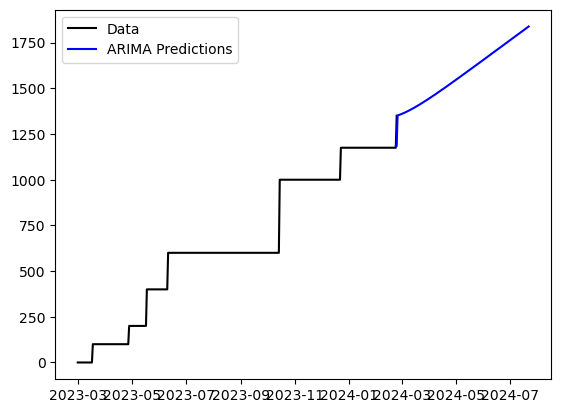

In [18]:
start = pd.Timestamp.now() - pd.Timedelta('1 days')
end = start + pd.Timedelta('150 days')
target_df = pd.DataFrame([{'cum_consumption': 0}, {'cum_consumption': 0}], index=[start, end])
target_df = target_df.resample("1D").sum()


target_df['Predictions'] = model.predict(start = target_df.index[0], end = target_df.index[-1])
target_df = target_df[['Predictions']]

plt.plot(df, color = "black", label = "Data")
plt.plot(target_df, color='blue', label = 'ARIMA Predictions')
plt.legend()

In [20]:
target_df.iloc[-1] - target_df.iloc[0]

Predictions    654.81549
dtype: float64

In [14]:
res = target_df['Predictions'] - df['cum_consumption'][-1]

In [15]:
res

2024-02-23   -169.542573
2024-02-24   -166.067813
2024-02-25      9.960323
2024-02-26      8.184390
2024-02-27      6.474165
                 ...    
2024-07-18    473.311521
2024-07-19    475.090232
2024-07-20    483.592793
2024-07-21    495.185235
2024-07-22    495.015842
Freq: D, Name: Predictions, Length: 151, dtype: float64

In [16]:
model2 = ARIMA(df, order = (1, 1, 1), trend='t')
model2 = model2.fit(low_memory=True)
model2.save('file3.pickle')

/home/aleks/.conda/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aleks/.conda/envs/jupyter/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
